In [1]:
%load_ext rmagic

/Library/Python/2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Curds and Whey Regression Applied to fMRI



 
# Introduction

When making inferences on multiple responses (Y), performance on each can be improved by pooling information across problems. Moreover, the amount of improvement depends in part on how similar the problems are. For fMRI data, inference is typically done for each individual voxel, but we anticipate that gains can be made by combining inference across multiple voxels. fMRI data is characterized by spatial correlations across voxels, some of which is due to a functionally-modular topographic organization of cortex. Therefore, this spatially correlated signal may make fMRI particularly conducive to a technique that joins inference across voxels. The particular techqnique we chose was the "Curds and Whey Regression" (CW) proposed by (Breiman and Friedman 1997)(BF). 

Our project has three major parts. First, we wanted to replicate the simulation results of Breiman and Friedman to verify that our implementation was correct, and assess CW's performance across a range of situations. Second, we wanted to apply CW to simulated fMRI data to assess its performance in a more realistic simulation. Finally, we applied CW to a real fMRI data set, in which we predict held out data in order to choose scientific models of cortical organization. 


# Background


## Setup 

Our setup is one of predicting multiple voxel response time courses given multiple experimental predictors (stimuli presented to the participant). We are interested in both predicting new voxel responses, and estimating the 'true' parameters underlying the voxel responses. 

The voxel responses at a given timepoint is a row vector $ \textbf{y'} = (y_1,...,y_q) $. We've assumed that each voxel's response can be described as a linear combination $ \beta $ of responses to our experimental manipulation $ \textbf{x}=(x_1,...,x_p) $ and additional zero-mean error. 

$$ y_i = \textbf{x} \beta_i + \epsilon_i $$
$$ y_q = \textbf{x} \beta_q + \epsilon_q $$



### OLS

In the typical approach to fMRI analysis, we stack the y's and x's across the n time points and solve using OLS, in which the estimation for each y is solved independently of all others.  

$$ \hat \beta_{ols} =  (\textbf{X}'\textbf{X})^{-1} \textbf{X}' \textbf{Y} $$
$$ \hat Y = \textbf{X} \hat \beta_{ols} $$

Although OLS is the minimum variance unbiased estimator, improvements in prediction can be made by shrinking the estimates towards zero. Copas (1983) showed that the expected slope of a regression of future y's on our OLS estimates $ \hat y $ will be too large. Therefore, his method and many others shrink the $ \hat y $ prior to prediction. 


### Ridge 

One such method is Ridge Regression which estimates the amount of shrinkage $ \lambda $ using cross-validation. We currently use Ridge on our data.

$$ \hat \beta_{rr} =  (\textbf{X}'\textbf{X} + I_p \lambda )^{-1} \textbf{X}' \textbf{Y} $$


### OLS-Curds-Whey

Both Ridge Regression and Copas's method shrink the OLS estimates based soley on x. BF proposed that further improvements can be made in situations with multiple responses. Their method is based multplying the OLS estimates by a shrinkage matrix S that incorporates the relationship between multiple y's and x's. 

$$  \hat Yhat = \textbf{X} \hat \beta_{ols} S^{cw} $$

BF derive the optimal shrinkage matrix (in an idealized setting), and highlight its relation to a canonical correlations analysis (CCA) of x and y. To see this, we start with the following combination of covariances for y and x,

$$ Q = E(yy^T)^{-1}E(yx^T)E(xx^T)^{-1}E(xy^T) $$

which BF show relates to optimal shrinkage in the following way (where r is the ratio of p/n):

$$ S^{cw} = ((1-r)I+rQ^{-T})^{-1} $$ 

In CCA, Q is usually decomposed into its eigenvectors and eigenvalues.

$$ Q = T C^2 T^{-1} $$

where T represents a new basis for Y in which the covariance between Y and X is a diagonal matrix C, and diagonals are maximized across all possible bases (for X and Y)(which are known the squared canonical correlations). Doing this, we can re-write the optimal shrinkage matrix as,

$$ S^{cw_optimal} = T D T^{-1} $$ 
$$ D = \frac{c^2}{c^2 + r(1-c^2)} $$ 

where $ c^2 $ are the diagonal elements of the $C^2$. 

Thus this decomposition uncovers what BF's shrinkage achieves. Multiplying $\hat Y$  by $ S^{cw_optimal} $ effectively transforms y into a new basis where x and y are maximally correlated, shrinks relative to the canonical correlations, and inversely transforms back. Intuitively, CCA has found a new basis for our voxels y and experimental manipulation x in which they have the strongest mutual relationship. For example, an important dimension in Y space may be one in which many voxels respond similarly to a certain experimental manipulation. Shrinkage by D will preserve this dimension while shrinking less important ones (ie. noise). 

In practice, we estimate Q with our observed data: 

$$ Q = E(yy^T)^{-1}E(yx^T)E(xx^T)^{-1}E(xy^T) $$

Then because our sample estimates for the values of  $ c^2 $ tend to be too high, we adjust those as well. Using generalized cross validation, we can approximate how much we should decrease the canonical correlations. 

$$ D = \frac{(1-r)(c^2-r)}{(1-r)^2c^2 + r^2(1-c^2)} $$ 

This is the D we use in our implementation. It is important to note that when q>p, there are only p canonical correlations. Therefore, like BF, we set those elements in D=0.



### Ridge-Curds-Whey

In situations where p is close to n, it may be beneficial to combine ridge and CW shrinkage. To do this, you multiply the estimates found via ridge regression by a similar shrinkage matrix. 

$$  \hat Yhat = \textbf{X} \hat \beta_{rr} S^{cw} $$

Two differences to the above procedure are that the CCA was done on $ (Y, \hat Y_{ridge}) $ rather than on (Y, X), and r is calculated using $ \frac{1}{N} trace ((\textbf{X}'\textbf{X} + I_p \lambda )^{-1} \textbf{X}') $, which can be considered the 'effective' degrees of freedom of the model. 

### Double Ridge 


As an alternative approach to using CW and CCA, we tried to estimate the optimal shrinkage directly by predicting predicting held out Y from $ \hat Y $ using cross validation with added L2-regularization:
 
$$ \hat S = argmin_{S} (||Y –  S  \hat Y|| + \gamma|| S|| $$
 
This is essentially a second step of ridge regression (i.e. ridge was first used to predict Y from X on a voxel-by-voxel basis, then for each voxel used to predict Y from $\hat Y$ of voxels in a surrounding neighborhood).
 
To determine the regularization parameter, $\gamma$ (to be distinguished $\lambda$ from the first ridge regression of Y onto X), we used 9-fold cross-validation in the estimation set. For each fold, $ S_k $ was chosen as
 
$$ S_k = argmin_S(||Y_{estimation,training fold} – S \hat Y_{estimation, training fold}|| + \lambda||S|| $$
 
And used to produce
 
$$ \hat Y_{new, estimation, testing fold} $$
 
After cross-validation, we selected the $ \gamma $ that resulted in the highest correlation between  $ (Y , S \hat Y) $. This was done separately for each voxel, i. 


# Part I: Simulations (BF)


## Summary

The two primary goals of these simulations were to verify our implementation of the CW shrinkage applied to OLS and Ridge Regression, and to identify situations in which it is most beneficial. We ran 50 simulations on each of the 4 models (excluding Double Ridge) with each of the following values of parameters:

* n observations (200,400)
* p parameters in our design matrix (11,21,51)
* q responses y (5,10,20,50)
* SNR (signal-to-noise ratio) (.01,.1,.5,1,2)
* bsig: variance in the distribution of true B (.01,.1,.5,1,2)


## Data Generation

The data for each simulation was generated in a similar fashion to BF. 

1.  X: Each x was chosen as a random draw from multivariate guassian with a covariance $ \textbf{V} $ that was itself randomly generated for each simulation. Each entry in the covariance was random number from -1 to 1.

2.  B: The true parameters were generated independently across x, but dependently across y. For each x, a random value was chosen from -1 to 1 to be the mean of the true parameter B. The B were then sampled from that guassian with a width determined by our free parameter (bsig). With a small variance, the y's would have similar B, a situation that should favor CW. 

3. F: The signal matrix was calculated as $ \beta XX^T \beta^T $. This was then used to adjust the error variance $\sigma$ so that different values of bsig would not adjust the overall SNR. $ \sigma $ was related to the overall signal so that SNR = mean(F)/sigma.

4. $ \epsilon $: Were independently drawn from a gaussian with mean zero and covariance $ I_q \sigma$ . 

5. We then divided into training and test sets (centering within each), fit the model on the training set and predicted the test set. We assessed performance on both the training set (estimation of true B) and the test set (prediction accuracy). 


## Performance Metrics

* **Estimation error**: As fMRI analyses are often aimed at estimating the effects of some experimental manipulation, we wanted to assess how well the models estimated the true parameters in the training set. Following BF we used the following loss function, where V is the true covariance used to generate the X. 

$$ est.mse = |\beta-\hat \beta|^T V |\beta - \hat \beta| $$


* **Prediction accuracy**: For predictive performance, we measure the correlation of each response $ y_i$ in the test set with its estimate $\hat y_i$




## Results: Overall 

Looking at the average performance across all simulations, CW performed better than OLS, ridge and CW performed similarly, and combining with ridge with CW performed the best. However, depending on the situation these relative performances shifted.  

In [3]:
%%R
library(gridExtra)
library(ggplot2)
load("BF_Sims.Rda")

Loading required package: grid


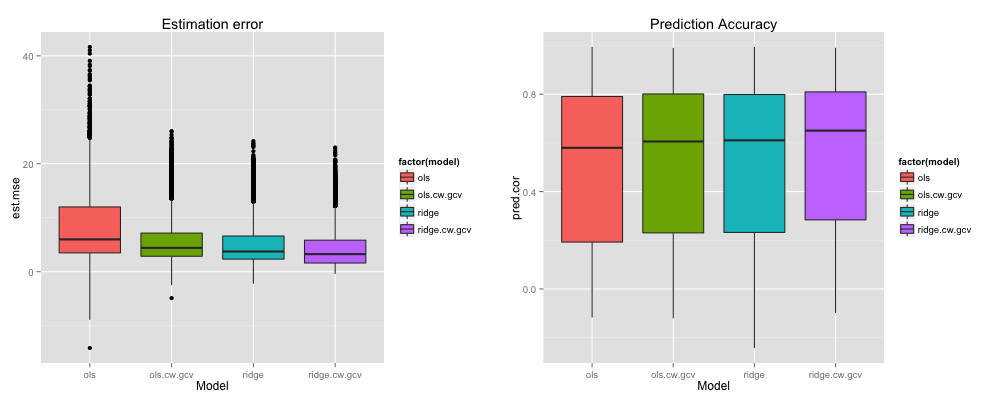

In [4]:
%%R -w 1000 -h 400

df1 <- subset(df, params.p < params.q )
p1<-ggplot(data=df,aes(x=model,y=est.mse,fill = factor(model)))+geom_boxplot()
p1<-p1+xlab('Model')+ggtitle('Estimation error')
p2<-ggplot(data=df,aes(x=model,y=pred.cor,fill = factor(model)))+geom_boxplot()
p2<-p2+xlab('Model')+ggtitle('Prediction Accuracy')
grid.arrange(p1,p2, nrow = 1, ncol = 2)

## Results: Signal-to-Noise

Averaging across all other parameters, we looked how the signal-to-noise ratio effected model performance. In general, prediction accuracy increased with SNR, however estimation MSE did not. Importantly, the effect of shrinking the estimates (either with ridge or CW) had improvements over OLS in cases of low SNR (0.01, 0.1) for both estimation and prediction.

In [5]:
%%R -w 600 -h 200

par(mfrow=c(1,2))
params=list(n=nn,p=pp,q=qq,bsig=.1,SNR=.1,modellist<-modellist)
data<-generate_data(params)
plot(seq(nn/2),data$Y.train[,1],type='l')
lines(seq(nn/2),data$X.train%*%data$B[,1],type='l',col='green')
title(main="Signal (XB) and Response Y: low SNR",xlab="observations", ylab="response (y)")


params=list(n=nn,p=pp,q=qq,bsig=.1,SNR=2,modellist<-modellist)
data<-generate_data(params)
plot(seq(nn/2),data$Y.train[,1],type='l')
lines(seq(nn/2),data$X.train%*%data$B[,1],type='l',col='green')
title(main="Signal (XB) and Response Y: high SNR",xlab="observations", ylab="response (y)")



Error in withVisible({ : object 'nn' not found
In addition: Warning message:
Removed 1761 rows containing non-finite values (stat_boxplot).
Error in withVisible({ : object 'nn' not found


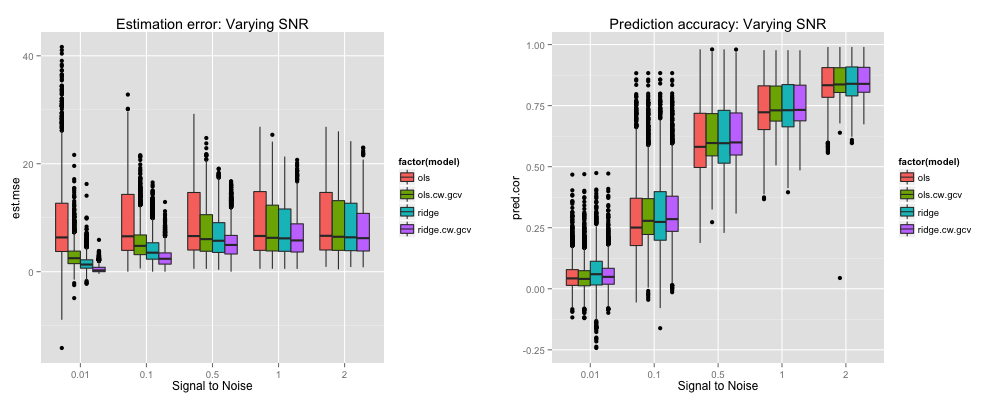

In [6]:
%%R -w 1000 -h 400
df1 <- subset(df, params.p > params.q  )
p1<-ggplot(data=df1,aes(x=factor(params.SNR),y=est.mse,fill = factor(model)))+geom_boxplot()
p1<-p1+xlab('Signal to Noise')+ggtitle('Estimation error: Varying SNR')
p2<-ggplot(data=df1,aes(x=factor(params.SNR),y=pred.cor,fill = factor(model)))+geom_boxplot()
p2<-p2+xlab('Signal to Noise')+ggtitle('Prediction accuracy: Varying SNR')
grid.arrange(p1,p2, nrow = 1, ncol = 2)

## Results: B variance 

Next, we averaged across all parameters except bsig, which determined the variance of B for each predictor. Low variance meant that B's were similar across voxels for a given predictor (left), whereas high variance meant that each voxel could have different B's (right). At each level of B variance, the SNR was kept constant by adjusting $ \sigma $ so the effects for this parameter on performance could be isolated.

The clearest benefit from CW is seen in prediction. For low variance in B's, CW applied to both OLS and Ridge improves peformance (right green/purple). This benefit decreases as the variance in the B's increases. For estimation MSE, Ridge actually seems to do better than CW, but more similuations need to be run, and the results might need to be subset by other factors


Loading required package: spam
Spam version 1.0-1 (2014-09-09) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

Attaching package: ‘pracma’

The following object is masked from ‘package:car’:

    logit

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:pracma’:

    expm, lu, tril, triu

Loading required package: foreach
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loaded glmnet 2.0-2



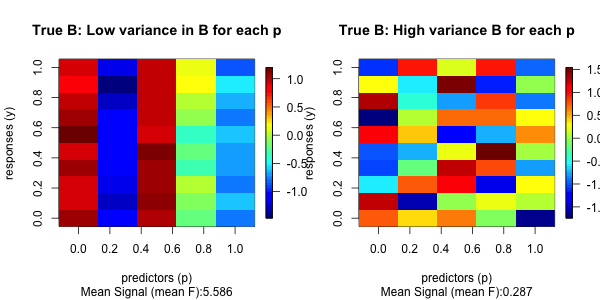

In [7]:
%%R -h 300 -w 600
library('fields')
source('Scripts_LinearModels.R')
modellist<-c("ols","ols.cw.gcv","ridge","ridge.cw.gcv")
qq=10
pp=5
nn=200



par(mfrow=c(1,2))
#oldpar <- par(mfrow=c(1,2), mar=c(1,1,1,1), oma=c(0,0,3,1))

params=list(n=nn,p=pp,q=qq,bsig=.1,SNR=1,modellist<-modellist)
data<-generate_data(params)
F = mean(t(data$B)%*%data$V%*%data$B)
image.plot(data$B) 
title(main="True B: Low variance in B for each p",sub=paste('Mean Signal (mean F)',round(F,3),sep=':'),xlab="predictors (p)", ylab="responses (y)")


params=list(n=nn,p=pp,q=qq,bsig=10,SNR=1,modellist<-modellist)
data<-generate_data(params)
F = mean(t(data$B)%*%data$V%*%data$B)
image.plot(data$B) ### shows covariance in beta's.. 
title(main="True B: High variance B for each p", xlab="predictors (p)", sub=paste('Mean Signal (mean F)',round(F,3),sep=':'),ylab="responses (y)")


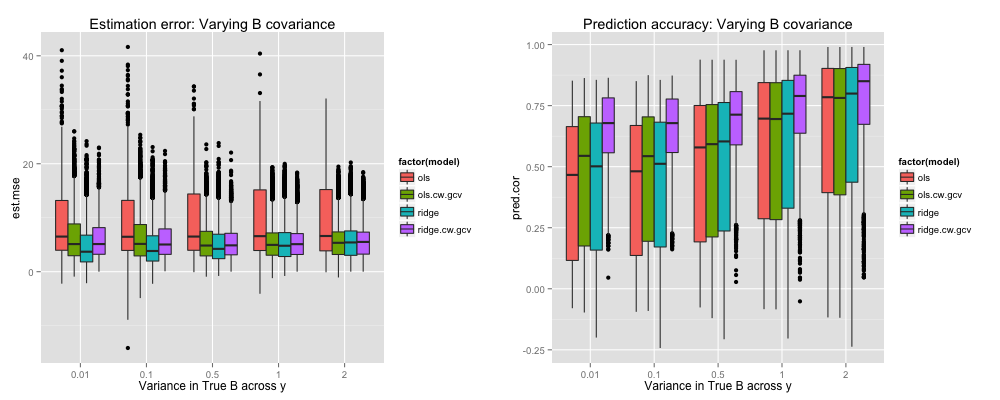

In [8]:
%%R -w 1000 -h 400
#df1 <- subset(df, params.p > params.q)
df1 <- subset(df, params.p > params.q  & succeed==1)
#df1 <-df
df1$params.bsig<-factor(df1$params.bsig)
#df1$params.bsig<-with(df1,factor(params.bsig, levels = rev(levels(params.bsig))))

p1<-ggplot(data=df1,aes(x=factor(params.bsig),y=est.mse,fill = factor(model)))+geom_boxplot()+ggtitle('Estimation error: Varying B covariance')
p1<-p1+xlab('Variance in True B across y')
p2<-ggplot(data=df1,aes(x=factor(params.bsig),y=pred.cor,fill = factor(model)))+geom_boxplot()+ggtitle('Prediction accuracy: Varying B covariance')
p2<-p2+xlab('Variance in True B across y')

grid.arrange(p1,p2, nrow = 1, ncol = 2)

# Part II: Simulations (fMRI)


### Summary

In this section, we wanted to extend the simulations to data more similar actual fMRI data. We simulated a simple experiment in which two conditions occurred in a random sequence for a total of 400 seconds. Each condition lasted 1 second (e.g. like an image presentation) and there was a delay between conditions. Several regions were simulated which each responded to one condition or the other. These are shown in the left two panels below. These spatial effects 'B1' and 'B2' were multiplied by the design matrix to create a temporal response for each voxel. Several types of noise were then added. For this particular simulation, we added zero-mean guassian and AR1 noise to each voxel's time course, and then spatial noise in the form of a gaussian random field with 5 voxel FWHM. The spatial average of the final simulated data is shown on the far right panel. The data simulation was done using a combination of in-house software, and some basic functions (e.g. gaussian random field) from the R package neuRosim. 

In [21]:
%%R -o mapYmean,mapEmean,mapB,underlay,dim1,dim2,tsXB,tsE
source('Scripts_fMRI_Simulations.R')

# maybe plot other noise types.....
#sigma=1
#n.white <- systemnoise(dim = 1, nscan = 200, sigma = sigma, type = "rician")
#n.low <- lowfreqdrift(dim =1, nscan =  200, TR = 2, freq = 120)
#n.phys <- physnoise(dim = 1, nscan =  200, sigma = sigma, TR = 2)
#n.temp <- temporalnoise(dim = 1, sigma =sigma, nscan = 200, rho = c(0.4, -0.2))
#plot(t(n.white),type='l')
#plot(t(n.low),type='l',col='green')
#plot(t(n.phys),type='l',col='blue')
#plot(t(n.temp),type='l',col='red')


design=list()
design$conditions = c(1,2)
design$TRS = 200
design$TRsec = 2
design$iti=c(1,3) # min max
design<-generate_event_design(design)


## Choose locations..  

map<-list()
map$dim2<-98
map$dim1<-98
map$coords = list(c(40,20),c(30,30),c(60,30),c(60,40))
map$radius = c(10,5,5,2) # chagne the fade its too narrow.. 
map$which.b = list(c(1),c(2),c(1),c(1)) # only one per now.. correspond to rows in design matri
map$maskname<-"mask.txt"
map$underlayname<-"underlay.txt"
map$SNR=1
map$weights<-c(.5,0,0,0,.5) #system, .., .., .., spatial 
map<-generate_regions_signal(design,map)

# some output for python plotting #
mapYmean<-apply(map$map.ts.Y,2,mean)
#mapXB<-map$map.ts.XB
mapEmean<-apply(map$map.ts.E,2,mean)
mapB<-map$map.B
underlay<-map$underlay
dim1<-map$dim1
dim2<-map$dim2
tsXB<-map$map.ts.XB
tsE<-map$map.ts.E

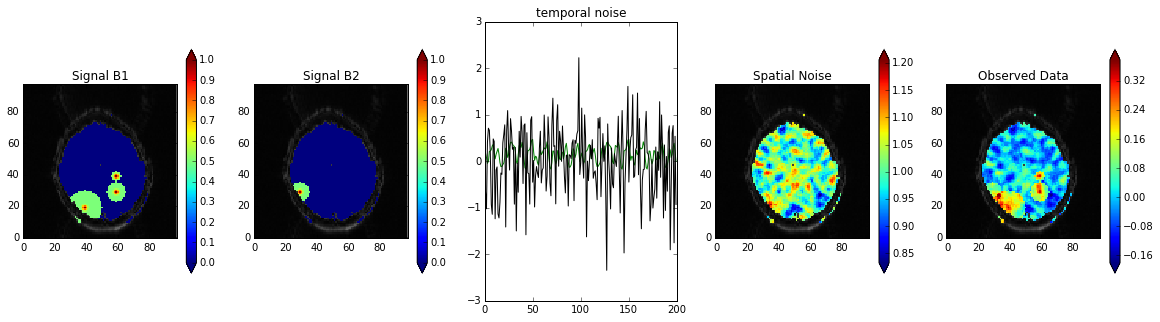

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


dim1=98
dim2=98
mapB=np.array(mapB)
mapYmean=np.array(mapYmean)
mapEmean=np.array(mapEmean)
underlay=np.array(underlay)

plt.figure(figsize=(20,5))

palette = cm.jet
palette.set_bad(alpha = 0.0)
#palette._lut[:,-1]=.8

palette2 = cm.gray
palette2.set_bad(alpha = 0.0)


### Signal 1
plt.subplot(1,5,1)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapB[:,0],(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both',orientation='vertical', shrink=0.8)
plt.title('Signal B1')

### Signal 2
plt.subplot(1,5,2)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapB[:,1],(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Signal B2')

plt.subplot(1,5,3)
tsXB=np.array(tsXB)
tsE=np.array(tsE)
plt.plot(tsXB[:,30*98-(98-42)],color='green')
plt.plot(tsE[:,30*98-(98-42)]-np.mean(tsE[:,30*98-(98-42)]),color='black')
plt.title('temporal noise')
#plot(map$map.ts.Y[,30*98-(98-42)],type='l',col='blue')
#lines(map$map.ts.XB[,30*98-(98-42)],type='l',col='green')

### Noise
plt.subplot(1,5,4)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapEmean,(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Spatial Noise')

### Noise
plt.subplot(1,5,5)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapYmean,(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Observed Data')


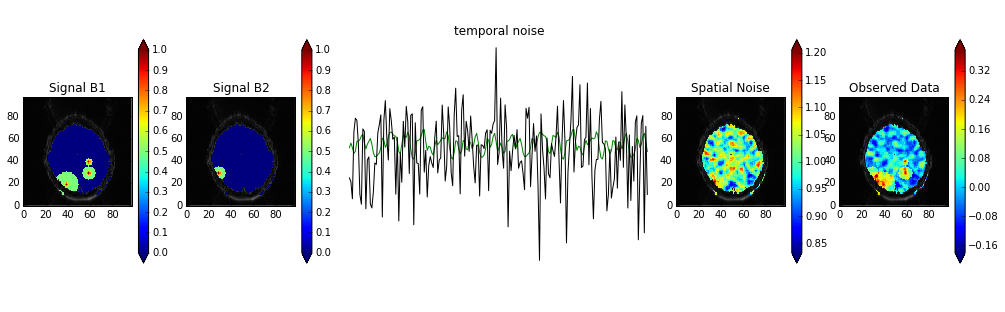

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


dim1=98
dim2=98
mapB=np.array(mapB)
mapYmean=np.array(mapYmean)
mapEmean=np.array(mapEmean)
underlay=np.array(underlay)

plt.figure(figsize=(20,5))

palette = cm.jet
palette.set_bad(alpha = 0.0)
#palette._lut[:,-1]=.8

palette2 = cm.gray
palette2.set_bad(alpha = 0.0)




### Signal 1
#plt.subplot(1,5,1)
plt.subplot2grid((1,7), (0, 1), colspan=1)

plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapB[:,0],(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both',orientation='vertical', shrink=0.8)
plt.title('Signal B1')

### Signal 2
plt.subplot2grid((1,7), (0,2), colspan=1)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapB[:,1],(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Signal B2')

ax=plt.subplot2grid((1,7), (0,3), colspan=2)
ax.axis('off')
tsXB=np.array(tsXB)
tsE=np.array(tsE)
plt.plot(tsXB[:,30*98-(98-42)],color='green')
plt.plot(tsE[:,30*98-(98-42)]-np.mean(tsE[:,30*98-(98-42)]),color='black')
plt.title('temporal noise',y=.9)
#plot(map$map.ts.Y[,30*98-(98-42)],type='l',col='blue')
#lines(map$map.ts.XB[,30*98-(98-42)],type='l',col='green')

### Noise
plt.subplot2grid((1,7), (0,5), colspan=1)

plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapEmean,(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Spatial Noise')

### Noise
plt.subplot2grid((1,7), (0,6), colspan=1)
plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
    cmap=palette2, origin='lower')
plt.imshow(np.reshape(mapYmean,(dim1,dim2)), interpolation='none',
    cmap=palette, origin='lower')
plt.colorbar( extend='both', orientation='vertical', shrink=0.8)
plt.title('Observed Data')


### Search-Light Curds-Whey

Instead of applying CCA to all voxels and our two predictors, we embedded CCA in a searchlight procedure. For each voxel, we took the 25 nearest voxels by euclidean distance. CCA was then calculated on these voxels and the predictors to get a shrinkage matrix. This matrix was applied to the predictions of voxel in the center of the searchlight, and the procedure was repeated for all voxels. Below is an example of the searchlight applied to the simulation. 

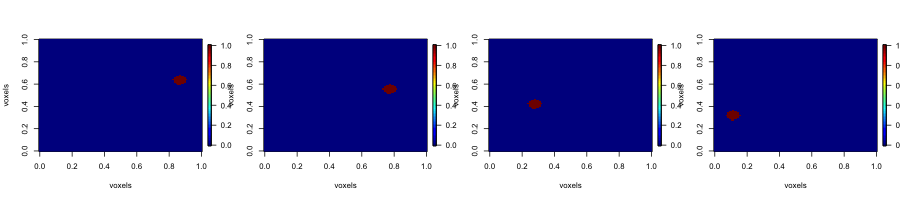

In [36]:
%%R -w 900 -h 200
distrank<-data.matrix(read.table("sim_distrank.txt"))
par(mfrow=c(1,4))
for (v in seq(4)){
    dd<-matrix(0,dim1*dim2)
    dd[distrank[sample(dim1*dim2,1),]]=1
    image.plot(matrix(dd,98,98))
    title(xlab="voxels", ylab="voxels")
}


### Results

In this simulation, we only looked at OLS and OLS-CW. Assessed by the same metrics as above, CW showed improvements over OLS. 

In [12]:
%%R -o mapsBhat,underlay
load("Sim_fmri_1.Rdata") #loads results3
mapsBhat<-results3$maps.Bhat
underlay<-results3$underlay

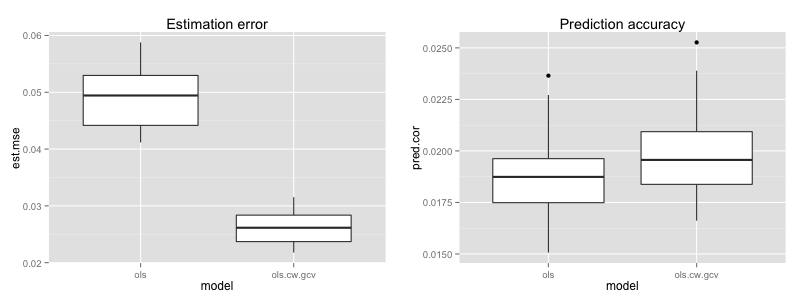

In [37]:
%%R -w 800 -h 300

df<-results3$df
df1 <- subset(df, model=='ols' | model=='ols.cw.gcv' )
p1<-ggplot(data=df1,aes(x=model,y=est.mse))+geom_boxplot()+ggtitle('Estimation error')
p3<-ggplot(data=df1,aes(x=model,y=pred.cor))+geom_boxplot()+ggtitle('Prediction accuracy')
grid.arrange(p1,p3, nrow = 1, ncol = 2)

Looking at maps of the B estimates (below), it is apparent that OLS-CW gave lower B weights to noise voxels that had B=0 (upper upper sections of the brain maps). 

(98, 98, 2, 4, 20)


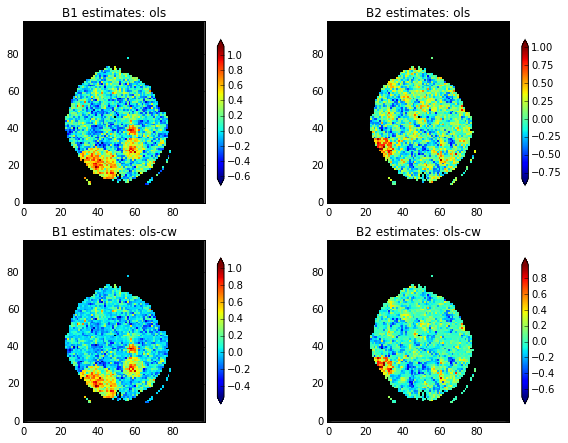

In [14]:
import numpy as np
dim1=98
dim2=98
mapsBhat=np.array(mapsBhat)
print(np.shape(mapsBhat))
#mapYmean=np.array(mapYmean)

averageit=0
palette = cm.jet
palette.set_bad(alpha = 0.0)
palette._lut[:,-1]=1

palette2 = cm.gray
palette2.set_bad(alpha = 0.0)

cc=1
plt.figure(figsize=(10,15))
for model in [0,1]:
    for b in range(2):
        plt.subplot(4,2,cc)
        #plt.imshow(np.reshape(underlay,(dim1,dim2)), interpolation='none',
        #cmap=palette2, origin='lower')
        
        if model==0:
            mname='ols'
        else:
            mname='ols-cw'
        
        # average
        if averageit:
            plt.imshow(np.mean(mapsBhat[:,:,b,model,:].T,axis=0), interpolation='none',
            cmap=palette, origin='lower')
            plt.colorbar(extend='both', orientation='vertical', shrink=0.8)
            cc=cc+1
        else:
            plt.imshow(mapsBhat[:,:,b,model,1].T, interpolation='none',
            cmap=palette, origin='lower')
            plt.colorbar(extend='both', orientation='vertical', shrink=0.8)
            plt.title('B'+str(b+1)+' estimates: '+mname)
            cc=cc+1

# Part III: fMRI Dataset


## Summary

Face perception is essential to human social interactions on a daily basis. It enables us to identify a virtually unlimited number of people, interpret a wide range of facial emotional cues, and draw rapid trait inferences from facial appearance. These abilities are made possible by a network of brain regions that seem to be largely dedicated to face perception, including the fusiform face area (FFA), occipital face area (OFA), and posterior superior temporal sulcus (pSTS).
 
While it is well understood that these brain regions activate in response to face images, it is less clear what aspects of face processing they each perform. Our approach is to measure brain activity in response to a large set of naturalistic faces, then use L2-regularized regression to see if we can predict brain activity as a function of different features of the images. Figure 1 shows how this works.

In general, we can compare the ability of different feature models to predict voxels in different regions across cortex. Here, for simplicity, we use only a semantic model. Membership of each face image in 102 semantic categories was independently determined by five naive raters and then averaged. 53 terms described variant facial attributes including 10 aspects of facial posture (e.g. mouth open, squinting) and 43 emotional expressions. The other 49 terms described invariant facial attributes such as gender and race.
 
The model was fit separately to the 1.92 hours of estimation data collected within each individual voxel. To model the slow hemodynamic response, variables within each model were assigned distinct time-inseparable finite impulse response filters with four bins at delays 2-4 s, 4-6 s, 6-8 s, and 8-10 s after stimulus onset. All model parameters were simultaneously fit using L2-regularized linear regression. The regularization parameter (λ) for regression was selected with nine-fold cross-validation. Each voxel’s prediction scores were taken as the correlation coefficient (Pearson's r) between the actual and predicted BOLD responses for that voxel. The optimal λ for all voxels was determined by testing ten values and selecting the one for which the maximum number of voxels had prediction scores exceeding a threshold r value (0.06). The model-fitting procedures were performed with in-house software written in Matlab (MathWorks). After fitting each voxelwise encoding model, the proportion of variance explained in each voxel was estimated by predicting the BOLD responses to the validation set and correlating these predictions with the data.
 


### Methods

Our goal was to use multi-output regression to improve the predictions of the semantic model. To that end, we tested two different formulations of multi-output regression as described above: searchlight Ridge-Curds-and-Whey and searchlight Double-Ridge. For each voxel, we only used the 25 nearest neighbors in either Ridge-CW or the second step of Double-Ridge. For both methods, the out-of-sample response estimates obtained during cross-validation to select λ in the estimation set were taken as $\hat Y$. For double-ridge, we used an additional 9-fold cross-validation within the estimation set to choose $\gamma$ and then retrained the second ridge step across all of the estimation data to estimate $\hat S$ for this $\gamma$. Finally, we adjusted our predictions of Y in the validation set with $S*\hat Y$ and correlated these adjusted predictions with our measured BOLD responses (Y). These correlations were compared to the correlations between our original $\hat Y$ and Y. 


In [15]:
from IPython.display import Image
Image(url='methodfig1.png')

These figures show a scatter plot of the voxel-wise prediction correlations when using searchlight Ridge-CW compared to Ridge (left), and searchlight Double-Ridge compared to Ridge (right). Points lying above the line correspond to voxels where there was an improvement using the new multi-response methods. In both cases, multi-response methods clearly improved correlations for the majority of relevant voxels, albeit by a small margin. 

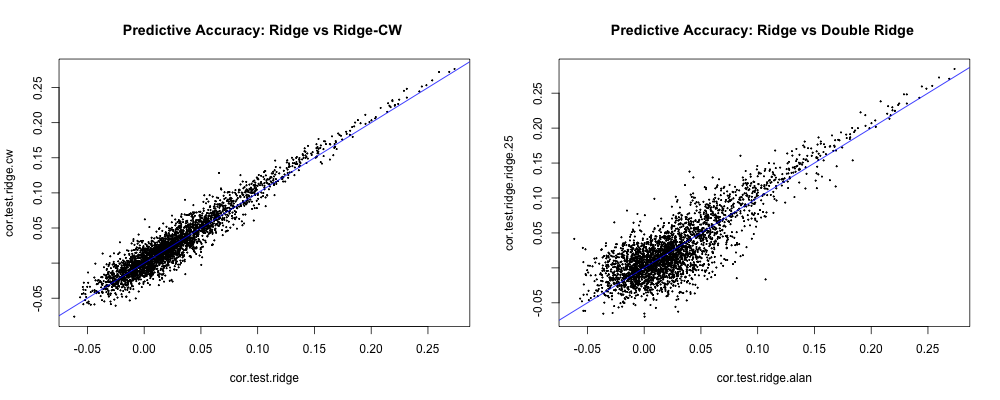

In [16]:
%%R -w 1000 -h 400


load('model_comparison_sig_cwrr25.Rdata')

par(mfrow=c(1,2))
plot(cor.test.ridge,cor.test.ridge.cw,cex=.2)
abline(b=1,a=0,col='blue')
title('Predictive Accuracy: Ridge vs Ridge-CW ')

cor.test.ridge.ridge.25<-data.matrix(read.table('YpredvalCorrRidge25NN.txt',sep=','))

cor.test.ridge.alan<-data.matrix(read.table('YpredvalCorrRidgeOrig.txt',sep=','))

#plot(cor.test.ridge.cw,cor.test.ridge.ridge.25)
plot(cor.test.ridge.alan,cor.test.ridge.ridge.25,cex=.2)
abline(b=1,a=0,col='blue')
title('Predictive Accuracy: Ridge vs Double Ridge ')

Below, we show the each voxel's prediction correlation on an inflated representation of the subject's cortex for Ridge (left) vs Double-Ridge (right). Outlined in green, is a region where noticeable improvement occured. 


In [17]:
from IPython.display import Image
Image(url='predmap1.png')


$$ \hat Q = (Y^tY)^{-1} (Y^tX) (X^tX)^{-1} (X^tY) = \hat T^{-1} \hat C^2 \hat T $$

$$ S = \hat T \hat D \hat T^{-1} $$


$$ \hat Y = \hat Y^{ols} S $$

$$ \hat Y = X(X^tX)^{-1} X^t Y S $$

$$ \hat Y^{cw} = X(X^tX)^{-1} X^t Y S $$

$$ \hat Y^{ridge cw} = X(X^tX+\lambda I)^{-1} X^t Y S $$

$$ \hat Y^{test} = \hat Y^{train} S $$

$$ \hat Y^{ridge} $$

$$ \hat Y^{ols} $$
